<h1>Indholdsfortegnelse<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot, os, dill
from scipy.spatial.distance import squareform

# import minepy as mp

In [2]:
# Load Data
data_path = "../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']

# load_variables = "v0_rxy v0_chi2 cosTheta v0_ks_mass v0_rxyErr pT ntrk_pv0 a0 calpha a0xy pv0_y".split(" ")
load_variables = data_tree.keys()[:57]
load_variables.remove(b"npv")

df = data_tree.pandas.df(load_variables, entrystop = 10**3)


In [3]:
# define probability variable
model_path = "models/data_trained_xg.dat"

func_seri = dill.load(open(model_path, 'rb'))
prob_func = dill.loads(func_seri)

In [4]:

df = prob_func(df)

<string>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
import pickle
update_pearson_matrix = True

mat = abs(np.array(df.corr()))
# pickle.dump((col, result), open("resources/pearson_corr.dat", 'wb'))


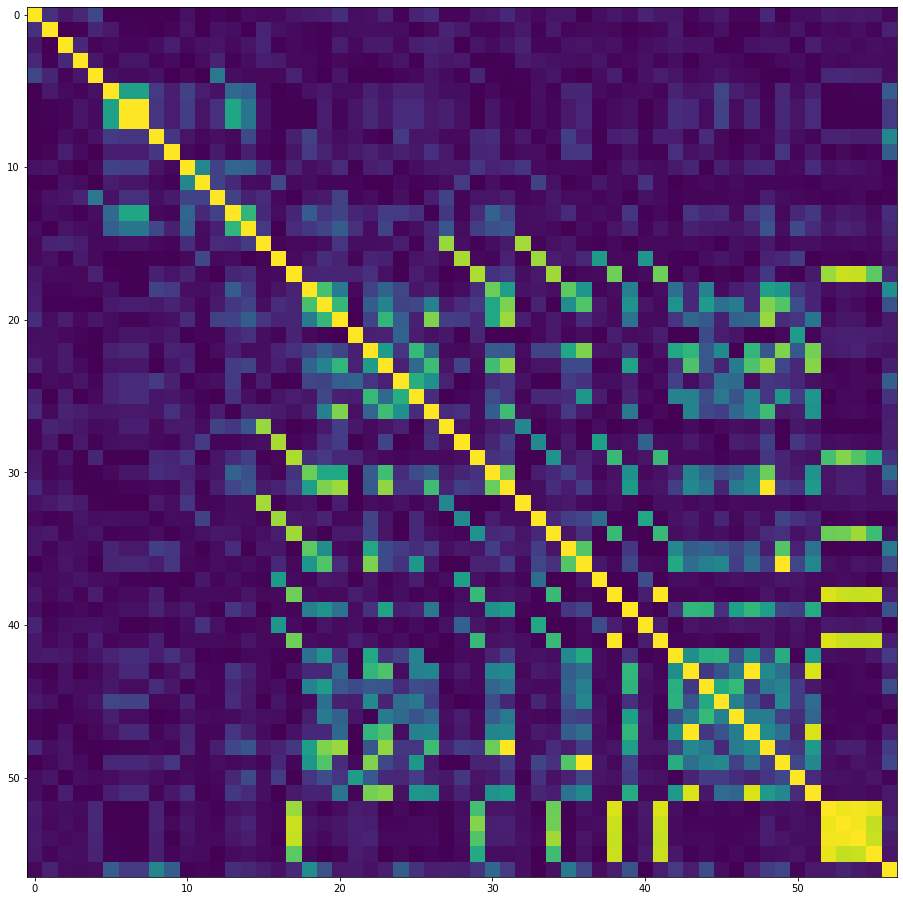

In [6]:
fig, ax = plt.subplots(figsize = (18, 16))
show = ax.imshow(mat) 
cols = df.columns

# for i in range(len(cols)):
#     for j in range(len(cols)):
#         text = ax.text(j, i, np.round(mat[i, j], 2),
#                        ha="center", va="center", color="w")

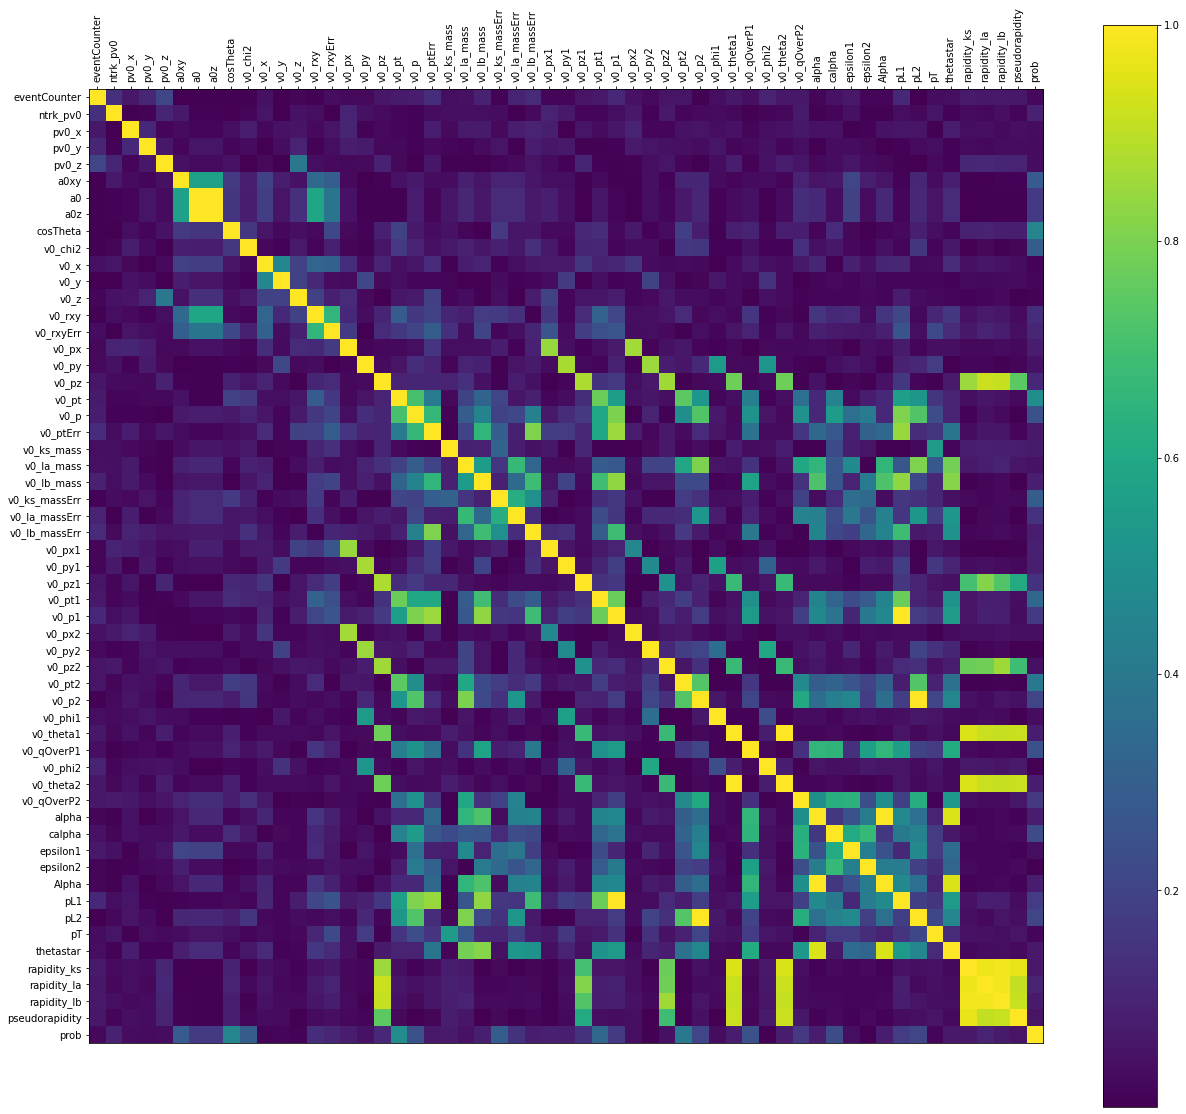

In [7]:
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation = 90)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)
# ax.xticks(rotation = 90)

fig.colorbar(show)

fig.tight_layout()
fig

In [8]:
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import squareform

last = ["v0_ks_mass", "prob"]

ind_last = np.array([list(cols).index(par) for par in last])

cols = list(cols)
for i in last:
    cols.remove(i)
cols = np.array(cols)
    
saved_rows = mat[:, ind_last]

cut_mat = np.delete(mat, ind_last, axis = 1)
cut_mat = np.delete(cut_mat, ind_last, axis = 0)


    


# dist = squareform(cut_mat)
dist = 1 - cut_mat
dist[dist < 0] = 0

# dist = np.ones_like(cut_mat)
# dist[(cut_mat > 0.2)] = 0

dist = squareform(dist)

Z = linkage(dist, method = "ward", optimal_ordering = True)
sort_ind = leaves_list(optimal_leaf_ordering(Z, dist))

# leaves_list(linkage(dist, optimal_ordering = True))

In [9]:
sorted_mat = cut_mat[:, sort_ind]
sorted_mat = sorted_mat[sort_ind, :]

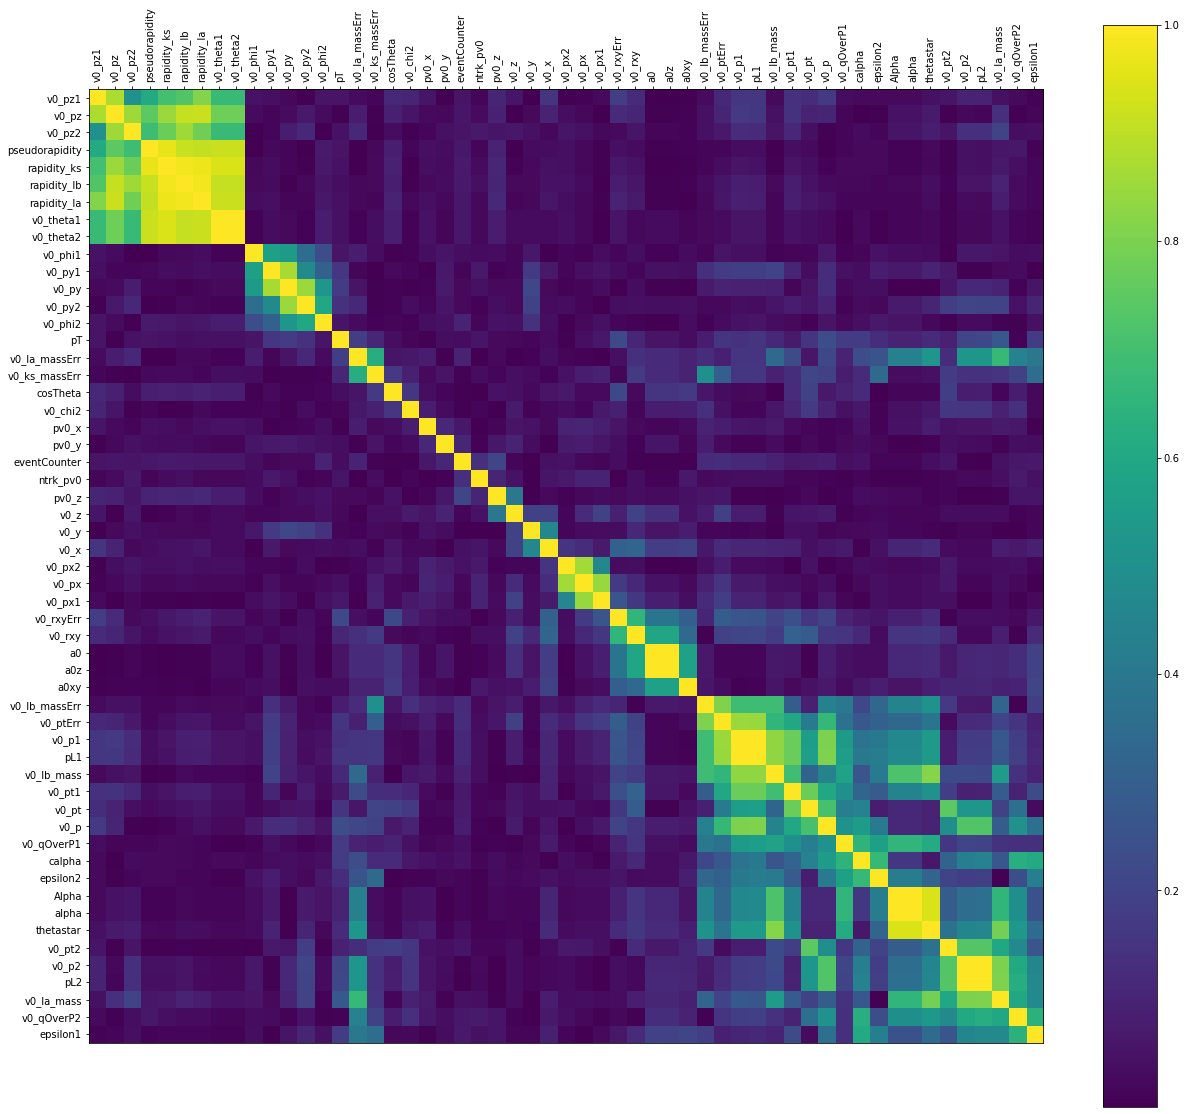

In [10]:
fig, ax = plt.subplots(figsize = (18, 16))
show = ax.imshow(sorted_mat)

ax.set_xticks(np.arange(len(sort_ind)))
ax.set_xticklabels(cols[sort_ind], rotation = 90)
ax.set_yticks(np.arange(len(sort_ind)))
ax.set_yticklabels(cols[sort_ind])
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)
# ax.xticks(rotation = 90)

fig.colorbar(show)

fig.tight_layout()
# fig


from scipy.cluster.hierarchy import fcluster
label = fcluster(Z, 1.6, criterion = 'distance')[sort_ind]
cuts = np.arange(len(label))[(label - np.roll(label, 1) == 1)]
cuts = np.hstack([0] + list(cuts) + [len(label)])

# cuts = [0, 16, len(label)]

# for line in cuts[1:-1]:#np.arange(len(label))[(label - np.roll(label, 1) == 1)] - 0.5:
#         ax.hlines(line - 0.5, 0, len(sort_ind) - 1, color = 'white', linestyle = 'dashed')
#         ax.vlines(line - 0.5, 0, len(sort_ind) - 1, color = 'white', linestyle = 'dashed')

# ax.hlines(5, 0, len(label), colors = 'white', linestyle = 'dashed')
# fig

In [11]:
cols = cols[sort_ind]

# cuts = [0, 16, len(cols)]
# params1 = cols[:6]
# params2 = cols[6:16]
# params3 = cols[16:]

params_list = [cols[cuts[i]:cuts[i+1]] for i in range(len(cuts) - 1)]

In [12]:
from iminuit import Minuit
from scipy.stats import norm, chi2
from ExternalFunctions import Chi2Regression, nice_string_output, add_text_to_ax
from scipy.optimize import curve_fit


def fit_data(xs, vals, errs, ax = None, guesses_bkgr = [0, 0, -10, 10000], guesses_sig = [498, 6, 17000]):
    if not ax:
        fig, ax = plt.subplots(figsize = (16, 10), ncols = 2)
        ax_sig = ax[1]
        ax_all = ax[0]
        ax_all.plot(xs, vals, 'r.')
        ax_all.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')

 
    # The background fit 
#     def background_fit(x, scale, loc, tau):
#         return scale * np.exp(- x / tau)
    
    def background_fit(x, a, b, c, d):
        return a * (x- 498) ** 3 + b * (x-498) ** 2 + c * (x-498) + d
    
    # The signal fit  Here gauss
    def add_signal(x, mean, sig, size):
        return size * norm.pdf(x, mean, sig)
    
    # The full fit
    def full_fit(x, mean, sig, size, a, b, c, d):
        return background_fit(x, a, b, c, d) + add_signal(x, mean, sig, size)
    
    # Background fit under here
    vals_b, cov_b = curve_fit(background_fit, xs, vals, p0 = guesses_bkgr)
    
    b1, b2, b3, b4 = vals_b
    
    bkgr_chi2 = Chi2Regression(background_fit, xs, vals, errs)
    bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
    
    bkgr_min.migrad()
    
    # Plot result and save guesses
    ax_all.plot(xs, background_fit(xs, *bkgr_min.args),'b--',  label = "background_fit")
    
    b1, b2, b3, b4 = bkgr_min.args
    s1, s2, s3 = guesses_sig
    
    # Full fit
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = s1, sig = s2, size = s3)
    
    full_min.migrad()
    
    s1, s2, s3, b1, b2, b3, b4 = full_min.args
    
    ax_all.plot(xs, full_fit(xs, *full_min.args), "k-", label = "full_fit")
    
    ax_all.legend(loc = "upper right")
    
    # Details:
    text = {'chi2': full_min.fval, \
            'pval': chi2.sf(full_min.fval, len(xs) - len(full_min.args)), \
            'mean': f"{full_min.values['mean']:.1f} +/- {full_min.errors['mean']:.1f}",\
            'N':    f"{full_min.values['size']:.1f} +/- {full_min.errors['size']:.1f}"}
    
    text_output = nice_string_output(text)
    add_text_to_ax(0.60, 0.925, text_output, ax_all)
    
    
    # Plot signal seperately
    ax_sig.fill_between(xs, add_signal(xs, s1, s2, s3), color = 'red', alpha = 0.5, label = "sig fit")
    
    vals_sig = vals - background_fit(xs, b1, b2, b3, b4)
    
    ax_sig.plot(xs, vals_sig, 'r.')
    ax_sig.errorbar(xs, vals_sig, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    
    sig_amount = np.sum(add_signal(xs, s1, s2, s3))
    bak_amount = np.sum(background_fit(xs, b1, b2, b3, b4))
    
    text_a = {'sig': np.round(sig_amount), \
              'bkgr': np.round(bak_amount), \
              's/b': sig_amount / bak_amount}
    
    text_output = nice_string_output(text_a, decimals = 2)
    add_text_to_ax(0.70, 0.90, text_output, ax_sig)
    
    fig.tight_layout()
    
    bak_func = lambda x: background_fit(x, b1, b2, b3, b4)
    sig_func = lambda x: add_signal(x, s1, s2, s3)
        
    return fig, ax, full_min, bak_func, sig_func, [s1, s2, s3, b1, b2, b3, b4]

In [13]:
df = data_tree.pandas.df(load_variables, entrystop = 10**5)

In [14]:
mass = df.v0_ks_mass
dfs = [df.loc[:, params] for params in params_list]

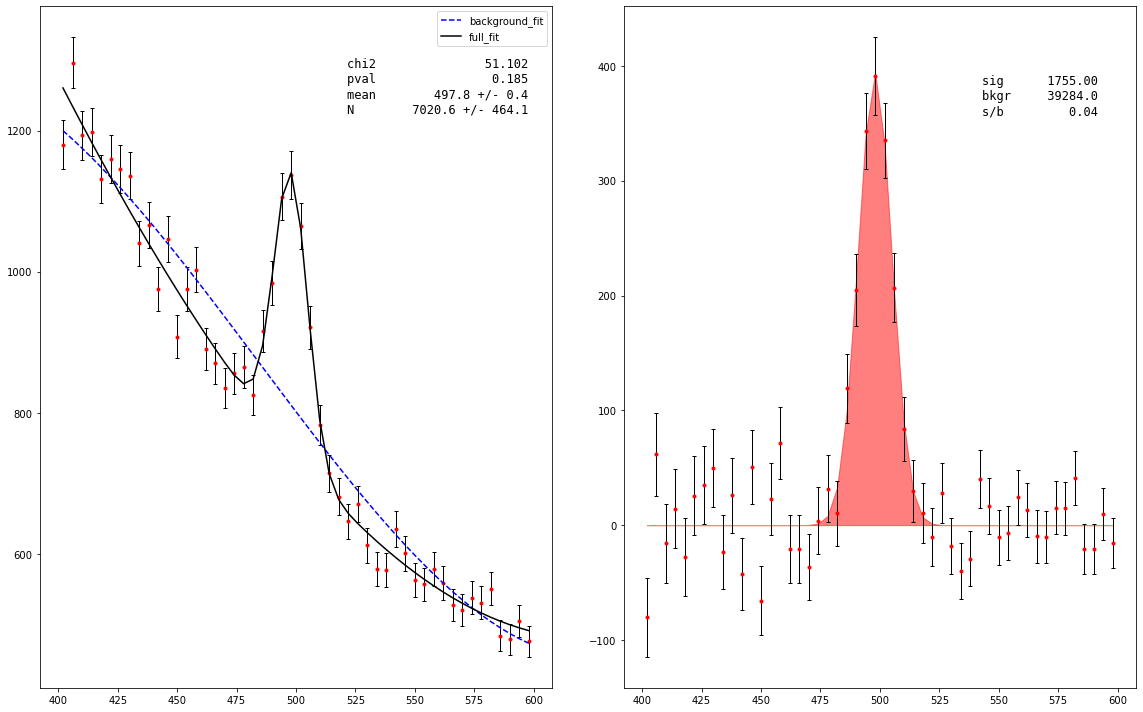

In [15]:
rang = (400, 600)
bins = 50

vals, edges = np.histogram(mass, range = rang, bins = bins)
xs = (edges[1:] + edges[:-1])/2

vals = vals[vals > 0]
xs = xs[vals > 0]


fig_cuts, ax_cuts, min_obj, bak, sig, varis = fit_data(xs, vals, np.sqrt(vals))

In [16]:
# Apply range
mass = mass[(mass > 400) & (mass < 600)]

# Take pseudo_true_sample
mean, sig = varis[0], varis[1]
pseudo_true = mass[abs(mass - mean) <  sig]

am = len(pseudo_true)

# True false
low_false = mass[mass  + 3 * sig < mean].sample(am)
high_false = mass[mass - 3 * sig > mean].sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target.loc[pseudo_true.index] = 1



In [17]:
from xgboost import XGBClassifier
models = []
for df in dfs:
    model = XGBClassifier()
    model.fit(df.loc[target.index, :], target)
    models.append(model)

In [18]:
probs = []
test_set = data_tree.pandas.df(load_variables, entrystart = 10**5, entrystop = 2 * 10 ** 5)
for model, params in zip(models, params_list):
    probs.append(model.predict_proba(test_set.loc[:, params])[:, 1])

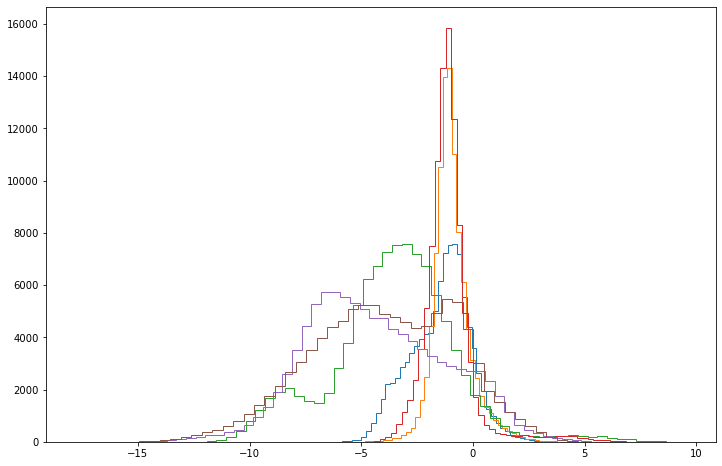

In [19]:
fig_probs, ax_probs = plt.subplots(figsize = (12, 8))

from scipy.special import logit


for prob in probs:
    ax_probs.hist(logit(prob), bins = 50, histtype = "step")

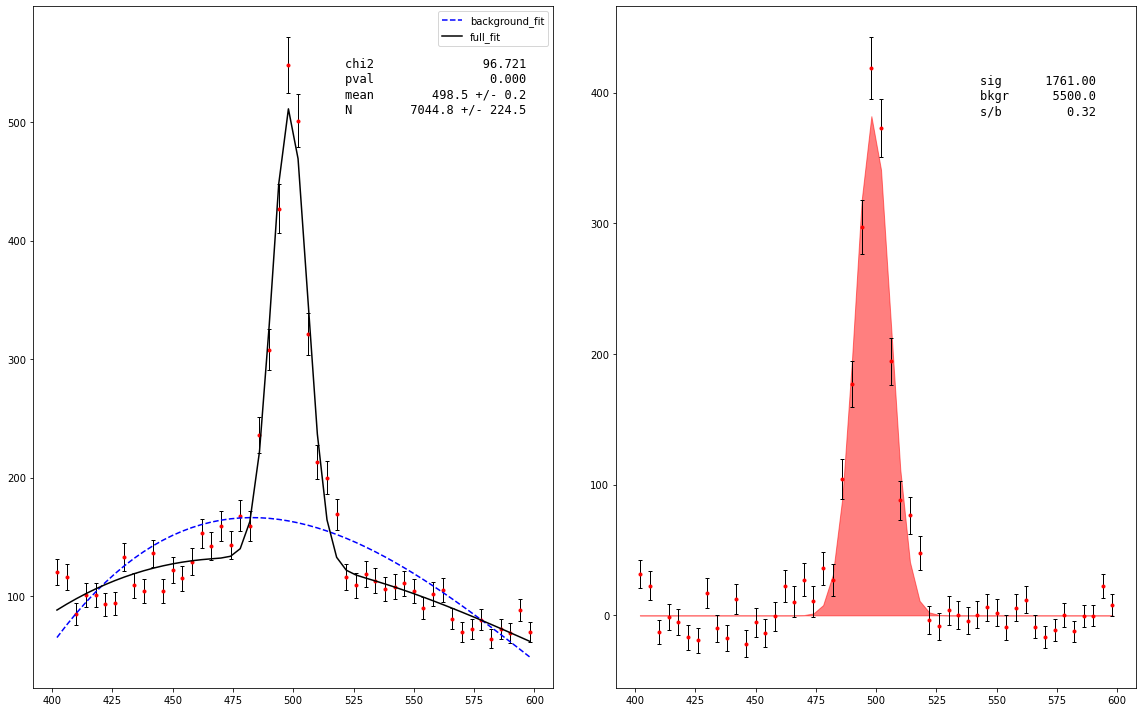

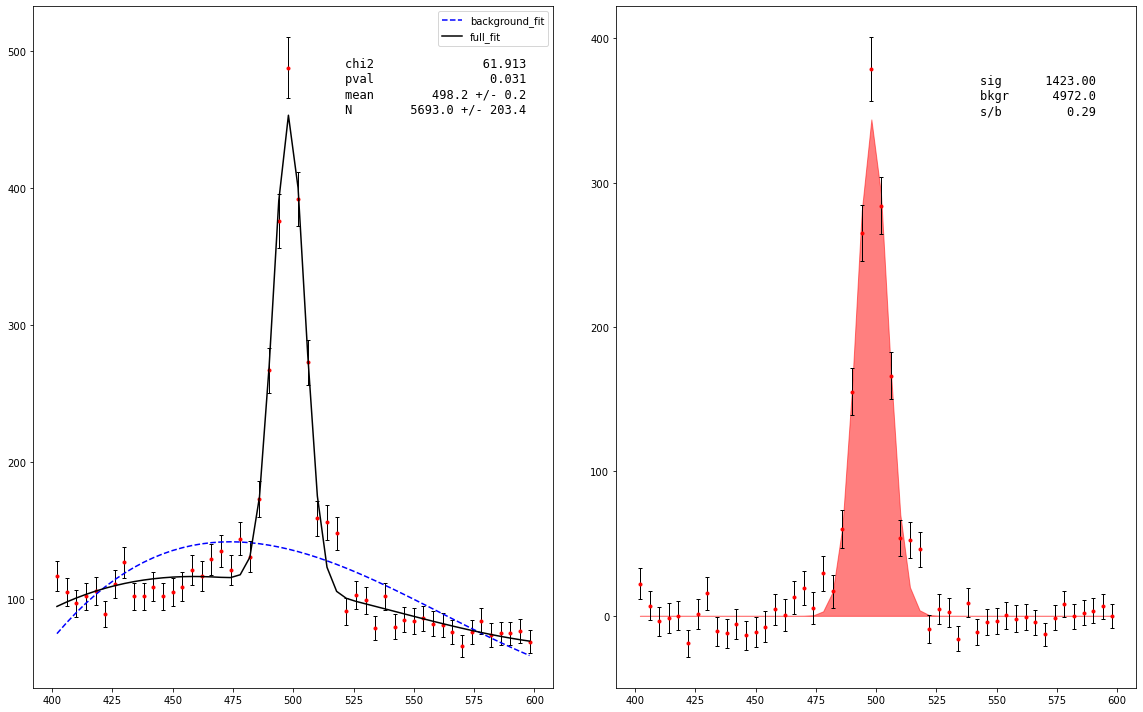

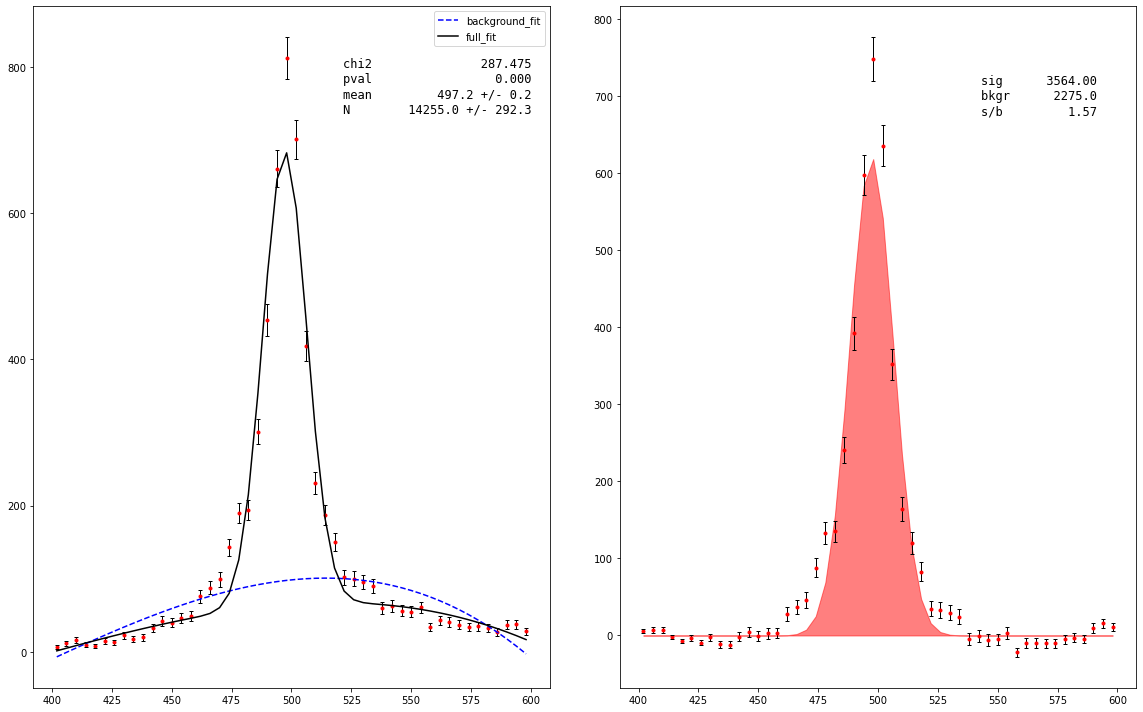

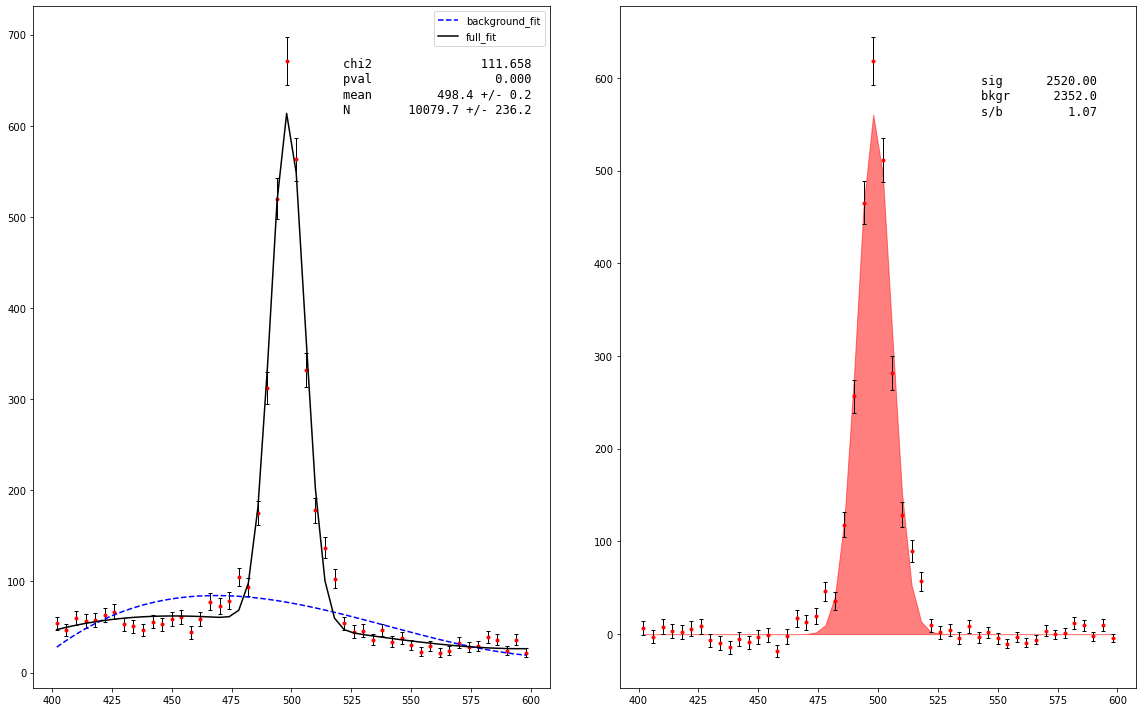

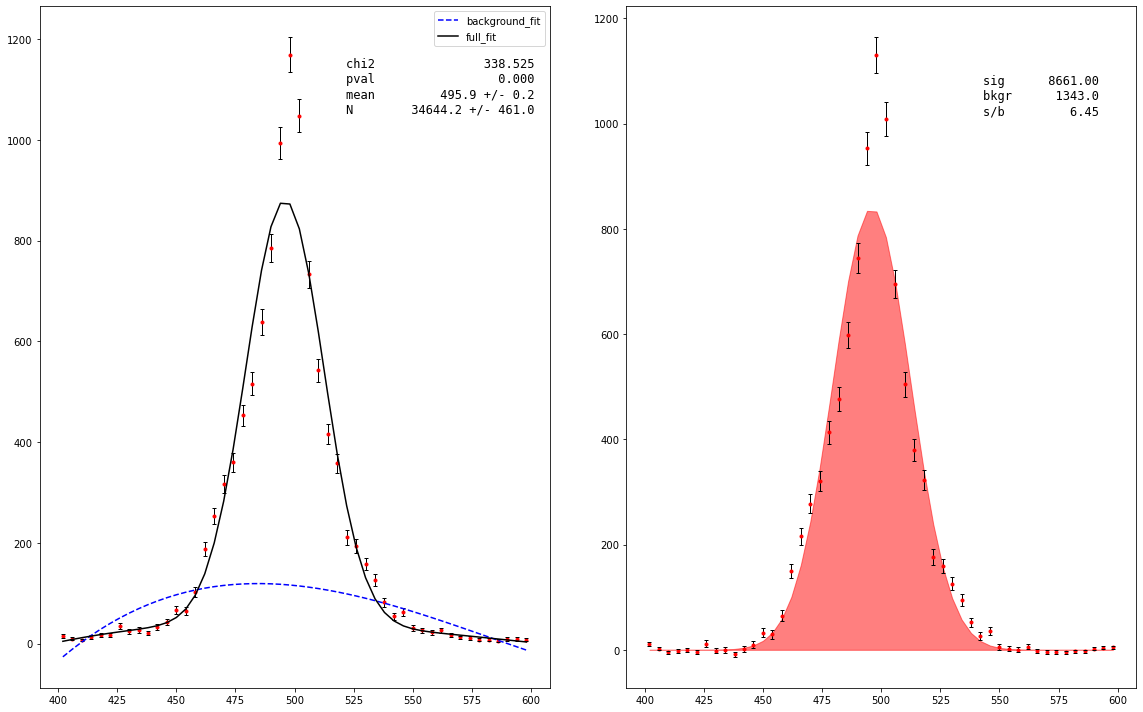

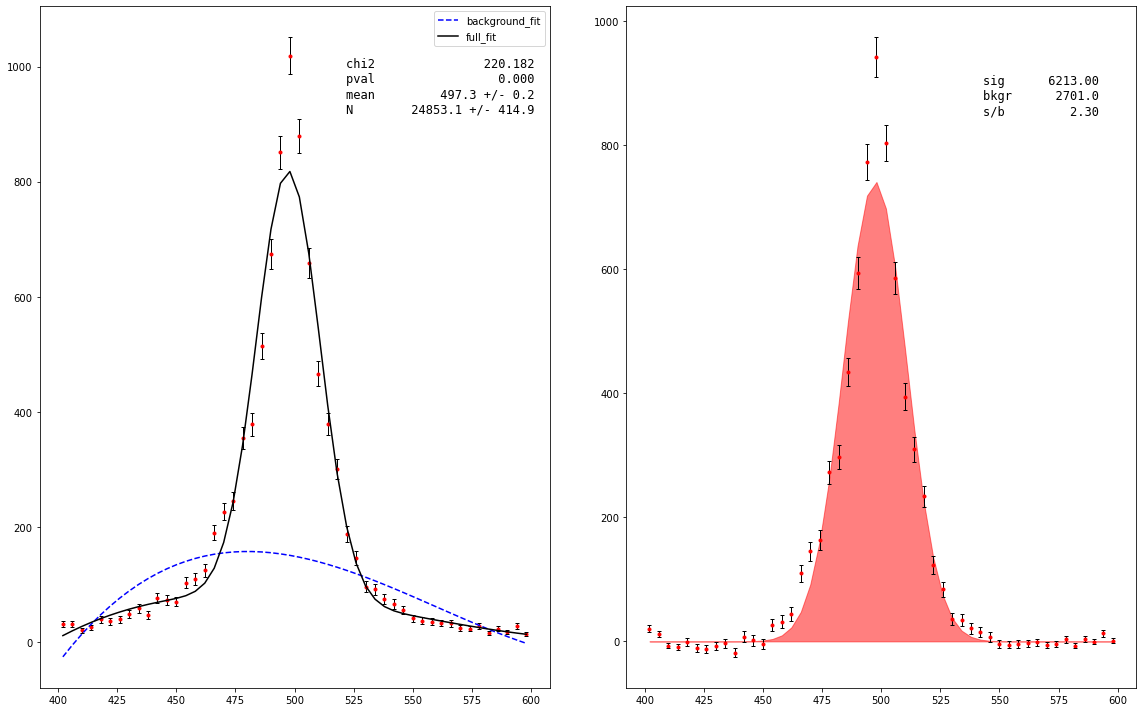

In [20]:
mass = test_set.loc[:, 'v0_ks_mass']
for model, params in zip(models, params_list):
    true = mass[model.predict(test_set.loc[:, params]) == 1]
    rang = (400, 600)
    bins = 50

    vals, edges = np.histogram(true, range = rang, bins = bins)
    xs = (edges[1:] + edges[:-1])/2
    
    mask = vals > 0
    
    vals = vals[mask]
    xs = xs[mask]

    fit_data(xs, vals, np.sqrt(vals));